In [1]:
import numpy as np
import numpy.linalg as LA
from sklearn.utils import murmurhash3_32
from random import randint
import matplotlib.pyplot as plt
#import stats
#import copy
import time
import multiprocessing
from scipy.special import factorial
import math
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import binom
from scipy.integrate import quad
from scipy.stats import multivariate_normal
from scipy.stats import mvn
from scipy.optimize import fsolve
from os.path import dirname, abspath, join
#from datasets import get_dataset, get_dataset_path
from datasets import get_dataset
import argparse
import pickle

In [2]:
def hashfunc(m):
    ss = randint(1, 99999999)
    def hash_m(x):
        return murmurhash3_32(x,seed=ss)%m
    return hash_m


class count_sketch():
    def __init__(self, n, k):
        self.n = n
        self.k = k
        self.table = np.zeros((n,k))
        self.hash_func = [hashfunc(n) for i in range(int(k))]
        self.sign_hash = [hashfunc(2) for i in range(int(k))]
        self.item_count = 0
        
    def insert(self, item, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        self.table[loc,np.arange(self.k)] += item * sign
        self.item_count += 1
        
    def insert_ID_list(self, item, index):
        index = index.reshape((len(index), 1))
        loc_array = np.apply_along_axis(lambda x: [Hash(x[0]) for Hash in sketch.hash_func], 1, index)
        sign_array = np.apply_along_axis(lambda x: [(-1)**Hash(x[0]) for Hash in sketch.sign_hash], 1, index)
        for i in range(loc_array.shape[0]):      
            self.table[loc_array[i],np.arange(self.k)] += item[i] * sign_array[i]
        
    def retrieve(self, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        return np.median(items)
    
    def retrieve_ID_list(self, index):
        index = index.reshape((len(index), 1))
        loc_array = np.apply_along_axis(lambda x: [Hash(x[0]) for Hash in sketch.hash_func], 1, index)
        sign_array = np.apply_along_axis(lambda x: [(-1)**Hash(x[0]) for Hash in sketch.sign_hash], 1, index)
        item_array = self.table[loc_array.flatten(), np.tile(np.arange(self.k), loc_array.shape[0])]
        item_array = item_array.reshape(loc_array.shape) * sign_array
        return np.median(item_array, axis = 1)
    
    def retrieve_item_list(self, index, VAR = False):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        if VAR:
            item_var = np.var(np.sort(item_list)[3:(self.k-3)])
            return items, item_var
        else:
            return items
    
#     def retrieve_var(self, index):
#         loc = np.array([self.hash_func[k](index) for k in range(self.k)])
#         sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
#         items = self.table[loc,np.arange(self.k)]*sign
#         return np.var(items)
    
    def clean():
        self.table = np.zeros((n,k))
        self.item_count = 0

        
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [3]:
#DATA_PATH = './gisette/gisette_scale.bz2'
#data = get_dataset_path(DATA_PATH)[0].toarray()
data = get_dataset("gisette")[0].toarray()

np.random.seed(100)
NUM_FEATURES_ORIGIN = 1000
NUM_SAMPLES_ORIGIN = data.shape[0]
## Split 1000 samples to filter the sparse features and 
## evaluate the standard deviation of the variables
NUM_SAMPLES_EXPLORE = 500
NUM_SAMPLES = 5500


In [4]:
print(data.shape)
num_features = data.shape[1]
num_samples = data.shape[0]
features = np.random.randint(0, num_features, NUM_FEATURES_ORIGIN)
#samples = np.random.randint(0, num_samples, NUM_SAMPLES_ORIGIN)
#data = data[samples[:,None],features]
data = data[:,features]

# Adjust to center around 0
data = data + 1

# mean_obs = np.apply_along_axis(np.mean, 0, data)
# # var_obs = (data - mean_obs).T@(data - mean_obs)/num_samples
# var_obs = data.T @ data / num_samples
print(data.shape)

(6000, 5000)
(6000, 1000)


In [5]:
## use 500 samples to filter the sparse features
mean_obs_sample = np.apply_along_axis(np.mean, 0, data[0:NUM_SAMPLES_EXPLORE,:])
#ADI#sparsity = (data[0:NUM_SAMPLES_EXPLORE,:] - mean_obs_sample[None,:] != 0)*1
#ADI#abundant_feature = np.apply_along_axis(np.sum, 0, sparsity)

## data_sample uses 500 samples to evaluate the standard deviation of the variables
data_sample = data[0:NUM_SAMPLES_EXPLORE,:]
data = data[NUM_SAMPLES_EXPLORE:(NUM_SAMPLES_ORIGIN),:]

## Number of features left
NUM_FEATURES = data.shape[1]

In [6]:
data.shape[1]

1000

In [7]:
with open('./gisette/results/sampled_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Determine the exploration period and thresholds

In [8]:
def miss_prop_at_t(x, n, R, k, sigma, signal, alpha, T, t):
    order_expect = -norm.ppf(((k - 1) / 2 - 0.375) / (k + 1 - 2 * 0.375))
    sigma_x = sigma * np.sqrt(1 / t + math.pi * (n - 1) * (1 - alpha) / (2 * k * t * (R - alpha)))
    percentile_1 = -x / sigma_x
    percentile_2 = -(x / sigma_x - order_expect)
    p = 0.5 + 0.5 * ((R - alpha) / R) ** (n - 1)
    prob_1 = p ** k
    prob_2 = k * (1 - p) * p ** (k - 1)
    
    print('Saturating probability:', 1 - prob_1 - prob_2)
    return prob_1 * norm.cdf(percentile_1) + prob_2 * norm.cdf(percentile_2) + (1 - prob_1 - prob_2)


def miss_prop_after_t(theta, Tau, n, R, k, sigma, signal, alpha, T, t):
    order_expect = -norm.ppf((k / 2 - 0.375) / (k + 1 - 2 * 0.375))
    var = math.pi * (n - 1) * (1 - alpha) * sigma ** 2 / (2 * k * (R - alpha))

    nu_0 = t / T * signal
    nu_1 = (signal - theta) / T
    nu_0_tilde = t / T * (signal - order_expect * np.sqrt(var / t))
    nu_1_tilde = 1 / T * (signal - theta - order_expect * np.sqrt(var) * (np.sqrt(t + 1) - np.sqrt(t)))

    omega_0 = np.sqrt(t / T ** 2 * (1 + var))
    omega_1 = omega_0 / np.sqrt(t)
    omega_0_tilde = omega_0
    omega_1_tilde = omega_1

    a1 = np.exp(-nu_0 ** 2 / (2 * omega_0 ** 2) + 2 * Tau * nu_1 / omega_1 ** 2 + (
                nu_0 - 2 * nu_1 * omega_0 ** 2 / omega_1 ** 2) ** 2 / (2 * omega_0 ** 2)) * \
         norm.cdf(((nu_0 - 2 * nu_1 * omega_0 ** 2 / omega_1 ** 2) - Tau) / omega_0)

    a2 = np.exp(-nu_0 ** 2 / (2 * omega_0_tilde ** 2) + 2 * Tau * nu_1_tilde / omega_1_tilde ** 2 +
                (nu_0_tilde - 2 * nu_1_tilde * omega_0_tilde ** 2 / omega_1_tilde ** 2) ** 2 / (
                            2 * omega_0_tilde ** 2)) * \
         norm.cdf(((nu_0_tilde - 2 * nu_1_tilde * omega_0_tilde ** 2 / omega_1_tilde ** 2) - Tau) / omega_0_tilde)

    p = 0.5 + 0.5 * ((R - alpha) / R) ** (n - 1)
    prob_1 = p ** k
    prob_2 = k * (1 - p) * p ** (k - 1)

    return a1 * prob_1 + a2 * prob_2

def find_best_exploration_period_m2(signal, alpha, init_threshold, num_features, cs_params, total_samples, target_miss_probability):
    '''
        signal : signal level (for correlation recommended is 0.2)
        alpha : proportion of signal variables . More of an upper bound . give reasonable value. (eg. 0.5% = 0.005)
        init_threshold : also called tau, threshold immediately after the exploration period.
             >> should be low enough so that we can have a small exploration period

        num_features : number of variables to insert in count sketch
        cs_params : dictionary where you can store the params of cs , expected keys K, R
        total_samples: total number of samples that will be added
        target_miss_probability : target miss probability (this should be low enough)
        
    '''
    #miss_prop_at_t(x, n=n, R=R, k=k, sigma=sigma, signal=signal, alpha=alpha, T=T, t=t):
    print(signal, alpha, init_threshold, num_features, cs_params, total_samples, target_miss_probability)

    sigma = np.sqrt(1 + signal**2) # TODO This is true only for correlations
    start = 1
    end = total_samples
    values = []
    mid = start
    while(end > start + 1):
        mid = int((start + end)/2)
        x = signal-init_threshold * total_samples / mid #TODO (zhenwei verify)
        prob = miss_prop_at_t(x, n=num_features, R=cs_params["R"],
                            k=cs_params["K"], sigma=sigma, signal=signal,
                            alpha=alpha, T=total_samples, t=mid)

        values.append((mid, prob))
        if prob > target_miss_probability:
            start = mid
        else:
            end = mid
    print(values)
    if total_samples - end < 2:
        print("The probability limit Failed! finding the approximate spurt point using error : 0.025")
        values = np.sort(values)
        selected = values[values[:,0] <= (values[:,0][-1] + 0.025)][0]
        print("selected", selected)
        return int(selected[1])
    else:
        return mid
    
    
def find_best_theta(signal, alpha, init_threshold, num_features, cs_params, total_samples, exploration_samples, target_miss_probability):
    #def miss_prop_after_t(theta, Tau, n, R, k, sigma, signal, alpha, T, t):
    start = 0.001
    end = signal - 0.001 # theta has to be less than signal
    # least count 
    least_count = 0.005 # 


    while(end > start + least_count):
        mid = (start + end)/2
        sigma = np.sqrt(1 + signal**2) # TODO This is true only for correlations
        prob = miss_prop_after_t(theta = mid, Tau = init_threshold,
                              n=num_features, R=cs_params["R"],
                              k=cs_params["K"], sigma=sigma,
                              signal=signal, alpha=alpha, T=total_samples,
                              t=exploration_samples)
        print(start, end, mid, prob)
        if prob < target_miss_probability:
            start = mid
        else:
            end = mid
    return start




In [11]:
n = NUM_FEATURES * (NUM_FEATURES-1) / 2
R = 20000
alpha = 5*10**(-3)
exploration_period = 340
T = NUM_SAMPLES
target_signal = 0.7
sigma = np.sqrt(1.0 + target_signal**2) # FIX1
k = 5

Tau = 0.01

print('prob at T_0: ', miss_prop_at_t(target_signal-Tau*T/exploration_period, n, R, k, sigma, target_signal, alpha, T, exploration_period))

theta = 0.41
print('prob during sampling: ', miss_prop_after_t(theta, Tau, n, R, k, sigma, target_signal, alpha, T, exploration_period))

Saturating probability: 0.030583327188786508
prob at T_0:  0.03572715372205368
prob during sampling:  0.007983192943159792


In [12]:
exploration_period = find_best_exploration_period_m2(target_signal, alpha, Tau, n, {"K":k, "R":R}, T, 0.05)
print("EXPLORATION PERIOD: ", exploration_period)
theta = find_best_theta(target_signal, alpha, Tau, n, {"K":k, "R":R}, T, exploration_period, 0.15)
print("THETA: ", theta)

0.7 0.005 0.01 499500.0 {'K': 5, 'R': 20000} 5500 0.05
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
Saturating probability: 0.030583327188786508
[(2750, 0.030583327188786508), (1375, 0.030583327238714972), (688, 0.03059349244630791), (344, 0.03536993316813619), (172, 0.13657791944783343), (258, 0.05312577936367579), (301, 0.04096579625126885), (279, 0.046019110698851534), (268, 0.04940573051626312), (263, 0.05118190343892018), (265, 0.05045214765655624), (266, 0.05009702851385227), (267, 0.0497482605

## Experiments

In [18]:
mean_obs = np.apply_along_axis(np.mean, 0, data)
var_obs = (data - mean_obs).T @ (data - mean_obs) / NUM_SAMPLES
cor_obs = correlation_from_covariance(var_obs)
var_diag = np.diag(var_obs)
var_off_diag = var_obs[np.triu_indices(NUM_FEATURES, k=1)]
cor_off_diag = cor_obs[np.triu_indices(NUM_FEATURES, k=1)]

mean_obs_sample = np.apply_along_axis(np.mean, 0, data_sample)
var_obs_sample = (data_sample - mean_obs_sample).T @ (data_sample - mean_obs_sample) / data_sample.shape[0]
var_diag_sample = np.diag(var_obs_sample)
var_off_diag_sample = var_obs_sample[np.triu_indices(NUM_FEATURES, k=1)]

ID = [x for x in range(len(var_off_diag))]
ID = np.array([str(x) for x in ID])

/home/apd10/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/home/apd10/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


In [19]:
## Number of signal variables
np.sum(np.abs(cor_off_diag)>target_signal), len(cor_off_diag)

(243, 499500)

In [25]:
data_norm = (data - mean_obs[None,:]) / (np.sqrt(var_diag)[None,:] + 1e-6)

batch_size = 100
block_end = list(np.arange(exploration_period, NUM_SAMPLES, batch_size)) + [NUM_SAMPLES]
block_start = [0] + block_end[:-1]


CS_RANGE = 20000
CS_REP = 5

sketch = count_sketch(CS_RANGE, CS_REP)
sketch.clean

for i, (start, end) in enumerate(zip(block_start, block_end)):
    data_batch = data_norm[start:end,:]
    var_batch = data_batch.T @ data_batch / NUM_SAMPLES
    var_off_diag_batch = var_batch[np.triu_indices(NUM_FEATURES, k=1)]
    
    ## Filtering
    if (i > 0):
        var_off_diag_batch = var_off_diag_batch[index_retain]
        ID_retain = np.array(ID)[index_retain]     
    else:
        index_retain = (np.ones(len(ID))>0)
        ID_retain = ID
    
    ## Insertion
    sketch.insert_ID_list(var_off_diag_batch, ID_retain)
    
    ## Retrieve
    var_off_diag_2 = sketch.retrieve_ID_list(ID)
    
    ## 
    sample_threshold = Tau + theta*i/NUM_SAMPLES*batch_size
    
    index_retain = (np.abs(var_off_diag_2) > sample_threshold)
    print(i,start,end, sample_threshold, np.sum(index_retain))
    
    #if (end==exploration_period) or ((end - block_end[0])  % 200 == 0):
    #    print(end, round(sample_threshold, 5), np.sum(index_retain), 
    #          np.sum(index_retain*(cor_off_diag>target_signal)))
        
        
with open('./gisette/results/CS_estimate(designed signal=%f).pickle' %target_signal, 'wb') as handle:
    pickle.dump(var_off_diag_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

0 0 267 0.01 174127
1 267 367 0.020825284090909092 51083
2 367 467 0.03165056818181818 17532
3 467 567 0.04247585227272728 7119
4 567 667 0.05330113636363637 3635
5 667 767 0.06412642045454546 2387
6 767 867 0.07495170454545455 1750
7 867 967 0.08577698863636364 1375
8 967 1067 0.09660227272727273 1152
9 1067 1167 0.10742755681818184 1003
10 1167 1267 0.11825284090909093 893
11 1267 1367 0.12907812500000002 798
12 1367 1467 0.13990340909090912 734
13 1467 1567 0.15072869318181822 705
14 1567 1667 0.1615539772727273 666
15 1667 1767 0.17237926136363638 628
16 1767 1867 0.18320454545454548 595
17 1867 1967 0.19402982954545459 577
18 1967 2067 0.2048551136363637 554
19 2067 2167 0.21568039772727277 538
20 2167 2267 0.22650568181818187 525
21 2267 2367 0.23733096590909095 511
22 2367 2467 0.24815625000000002 496
23 2467 2567 0.2589815340909091 482
24 2567 2667 0.26980681818181823 469
25 2667 2767 0.28063210227272734 465
26 2767 2867 0.29145738636363644 455
27 2867 2967 0.3022826704545455 4

Best F1 Score:  0.908695652173913


/home/apd10/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


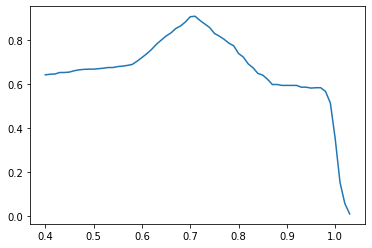

[0.64167916 0.64457831 0.64555053 0.65243902 0.65243902 0.65443425
 0.66049383 0.66459627 0.66666667 0.66770671 0.66770671 0.66979656
 0.67189953 0.67507886 0.67507886 0.67936508 0.68152866 0.6848
 0.68921095 0.70394737 0.72053872 0.73793103 0.75752212 0.7810219
 0.8        0.81835564 0.83268482 0.85258964 0.86464646 0.88247423
 0.90638298 0.90869565 0.88988764 0.87356322 0.85780886 0.83054893
 0.81840194 0.80392157 0.78606965 0.77386935 0.73901809 0.72251309
 0.69168901 0.67391304 0.64819945 0.64066852 0.62146893 0.59770115
 0.59770115 0.59365994 0.59365994 0.59365994 0.59365994 0.58550725
 0.58550725 0.58139535 0.58309038 0.58309038 0.56637168 0.51376147
 0.35254237 0.15209125 0.056      0.00819672]


In [32]:
off_diag = cor_obs[np.triu_indices(NUM_FEATURES, k=1)] 

F1_score = []
precision_list = []
recall_list = [] 


threshold_list = np.arange(0.4, 1.1, 0.01)
for thres in threshold_list:
    positive_index = (np.abs(off_diag)>target_signal)
    predict_positive_index = (np.abs(var_off_diag_2)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)

    ## Deviation from the true covariance matrix
    F1_score += [2*precision*recall/(precision+recall)]
    precision_list += [precision]
    recall_list += [recall]
    
F1_score = np.array(F1_score)
mask = ~ np.isnan(F1_score)
    
print('Best F1 Score: ', np.max(F1_score[mask]))

plt.plot(threshold_list[mask], F1_score[mask])
plt.show()

# plt.plot(threshold_list, precision_list)
# plt.show()

# plt.plot(threshold_list, recall_list)
# plt.show()

# plt.plot(1 - np.array(precision_list), np.array(recall_list))
# plt.xlabel('1 - Precision')
# plt.ylabel('Recall')
# plt.show()
print(F1_score[mask])

/home/apd10/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


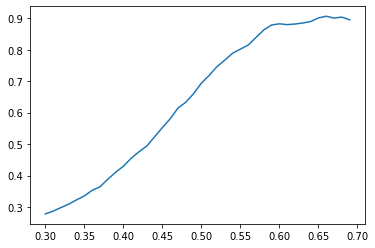

In [33]:
max_F1_score_list = []

signal_list = np.arange(0.3, 0.7, 0.01)

for signal in signal_list:
    max_F1_score = 0
    for thres in np.arange(signal-0.1, signal+0.4, 0.01):
        positive_index = (np.abs(off_diag)>signal)
        predict_positive_index = (np.abs(var_off_diag_2)>thres)
        fn = np.sum(positive_index*(1-predict_positive_index))
        tp = np.sum(predict_positive_index*positive_index)
        
        if np.sum(predict_positive_index) > 0:
            precision = tp/np.sum(predict_positive_index)
        else:
            precision = 0
        recall = tp/(tp+fn)

        ## Deviation from the true covariance matrix
        max_F1_score = max(max_F1_score, 2*precision*recall/(precision+recall))
    max_F1_score_list += [max_F1_score]
    
plt.plot(signal_list, max_F1_score_list)
plt.show()



# with open('./gisette/results/max_F1_score_list(designed signal=%f).pickle' %target_signal, 'wb') as handle:
#     pickle.dump(max_F1_score_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

(5500, 1000)

## Conventional Count Sketch

In [45]:
CS_RANGE = 20000
CS_REP = 5

sketch = count_sketch(CS_RANGE, CS_REP)
sketch.clean

data_norm = (data - mean_obs[None,:]) / (np.sqrt(var_diag)[None,:] +  1e-6)
cor_off_diag = (data_norm.T @ data_norm / NUM_SAMPLES)[np.triu_indices(NUM_FEATURES, k=1)]

for item, mem_id in zip(cor_off_diag, ID):
    sketch.insert(item, mem_id)

var_off_diag_3 = []
# CMS_var = []
for mem_id in ID:
    var_off_diag_3 += [sketch.retrieve(mem_id)]
    
# var_off_diag_prod_2 = []
# var_off_diag_sign_2 = []
# for mem_id in ID:
#     item_list = np.sort(sketch.retrieve_item_list(mem_id))
#     var_off_diag_prod_2 += [np.prod(item_list[1:(sketch.k-1)])]
#     var_off_diag_sign_2 += [np.sum(np.sign(item_list))]


# with open('./gisette/results/CS_estimate(vanilla_CS).pickle', 'wb') as handle:
#     pickle.dump(var_off_diag_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

Best F1 Score:  0.7845804988662131


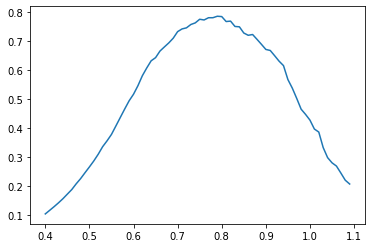

In [46]:
off_diag = cor_obs[np.triu_indices(NUM_FEATURES, k=1)]

F1_score_2 = []
precision_list_2 = []
recall_list_2 = []

threshold_list = np.arange(0.4, 1.1, 0.01)
    
for thres in threshold_list:
    positive_index = (np.abs(off_diag)>target_signal)*1
    predict_positive_index = (np.abs(var_off_diag_3)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score_2 += [2*precision*recall/(precision+recall)]
    precision_list_2 += [precision]
    recall_list_2 += [recall]

    
print('Best F1 Score: ', np.max(F1_score_2))
plt.plot(threshold_list, F1_score_2)
plt.show()

[0.47286594309181584, 0.48020706455542017, 0.4871974745703262, 0.49626078619367203, 0.5034382162950615, 0.5107256960292104, 0.518426294820717, 0.5236382322713258, 0.5327253218884119, 0.54241267977693, 0.5474824729126833, 0.5527538155275382, 0.5575620767494357, 0.5654368932038836, 0.576091751213057, 0.5844454670961804, 0.5874751491053678, 0.5987406983400114, 0.6041666666666667, 0.6095238095238095, 0.6187335092348285, 0.6205023761031908, 0.6279640228945217, 0.6461808604038629, 0.6547169811320754, 0.6634335596508244, 0.6686449060336301, 0.671067106710671, 0.688, 0.6939252336448598, 0.6956521739130436, 0.7165021156558533, 0.7299270072992702, 0.7443946188340808, 0.7553516819571865, 0.7578616352201258, 0.7699680511182109, 0.7707317073170731, 0.7714285714285714, 0.7763157894736842]


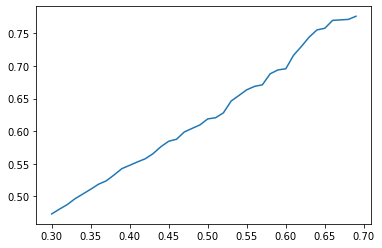

In [47]:
max_F1_score_list_2 = []


for signal in signal_list:
    max_F1_score = 0
    for thres in np.arange(signal-0.1, signal+0.4, 0.01):
        positive_index = (np.abs(off_diag)>signal)
        predict_positive_index = (np.abs(var_off_diag_3)>thres)
        fn = np.sum(positive_index*(1-predict_positive_index))
        tp = np.sum(predict_positive_index*positive_index)

        precision = tp/np.sum(predict_positive_index)
        recall = tp/(tp+fn)

        ## Deviation from the true covariance matrix
        max_F1_score = max(max_F1_score, 2*precision*recall/(precision+recall))
    max_F1_score_list_2 += [max_F1_score]
print(max_F1_score_list_2)
plt.plot(signal_list, max_F1_score_list_2)
plt.show()
    
# with open('./gisette/results/max_F1_score_list(vanilla_CS).pickle', 'wb') as handle:
#     pickle.dump(max_F1_score_list_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

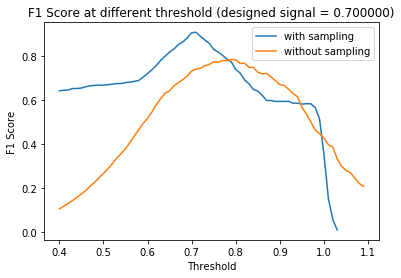

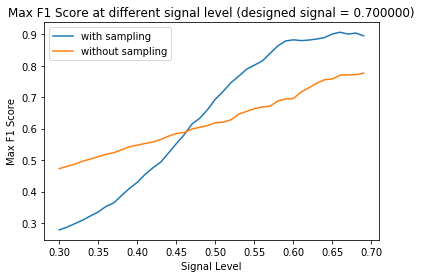

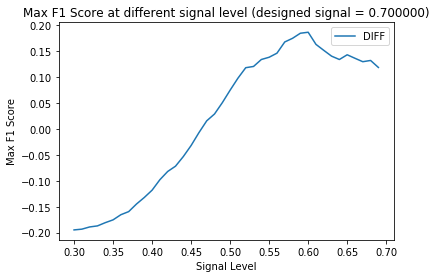

In [48]:
# threshold_list = np.arange(0.3, 1.1, 0.005)

plt.plot(threshold_list, F1_score, label = 'with sampling')
plt.plot(threshold_list, F1_score_2, label = 'without sampling')
plt.title('F1 Score at different threshold (designed signal = %f)' %target_signal)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
# plt.savefig('./Figures/Gisette/F1_score_using_different_thresholds(designed signal=%f).png' %target_signal)
plt.show()



plt.plot(signal_list, max_F1_score_list, label = 'with sampling')
plt.plot(signal_list, max_F1_score_list_2, label = 'without sampling')
plt.title('Max F1 Score at different signal level (designed signal = %f)' %target_signal)
plt.xlabel('Signal Level')
plt.ylabel('Max F1 Score')
plt.legend()
# plt.savefig('./Figures/Gisette/Max_F1_score_at_different_signal_level(designed signal=%f).png' %target_signal)
plt.show()




plt.plot(signal_list, np.array(max_F1_score_list) - np.array(max_F1_score_list_2), label = 'DIFF')
plt.title('Max F1 Score at different signal level (designed signal = %f)' %target_signal)
plt.xlabel('Signal Level')
plt.ylabel('Max F1 Score')
plt.legend()
# plt.savefig('./Figures/Gisette/Max_F1_score_at_different_signal_level(designed signal=%f).png' %target_signal)
plt.show()

## Summary plot

In [38]:
# with open('./gisette/results/max_F1_score_list(designed signal=0.5).pickle', 'rb') as handle:
#     max_F1_list_1 = pickle.load(handle)
    
# with open('./gisette/results/max_F1_score_list(designed signal=0.6).pickle', 'rb') as handle:
#     max_F1_list_2 = pickle.load(handle)
    
# with open('./gisette/results/max_F1_score_list(vanilla_CS).pickle', 'rb') as handle:
#     max_F1_list_3 = pickle.load(handle)
    
    

# plt.plot(signal_list, max_F1_list_1, label = 'designed signal level = 0.5')
# plt.plot(signal_list, max_F1_list_2, label = 'designed signal level = 0.6')
# plt.plot(signal_list, max_F1_list_3, label = 'vanilla count sketch')
# plt.title('Max F1 Score at different signal level (designed signal = %f)' %target_signal)
# plt.xlabel('Signal Level')
# plt.ylabel('Max F1 Score')
# plt.legend()
# plt.savefig('./Figures/Gisette/Max_F1_score_at_different_signal_level(designed signal=%f).png' %target_signal)
# plt.show()